In [1]:
import numpy as np
import pandas as pd 
from tqdm import tqdm 
from sentence_transformers import SentenceTransformer, util, models
import os 
import random 
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
def split_text(s, overlap = 20, chunk_size = 100): 
    total = [] 
    partial = [] 
    if len(s.split()) // (chunk_size - overlap) > 0:  
        n = len(s.split()) // (chunk_size - overlap) 
    else: 
        n = 1 
    for w in range(n): 
        if w == 0: 
            partial = s.split()[:chunk_size] 
            total.append(" ".join(partial)) 
        else:  
            partial = s.split()[w*(chunk_size - overlap):w*(chunk_size - overlap) + chunk_size]
            total.append(" ".join(partial)) 
    return total


In [3]:
def format_data(splitted, max_parts = 50):
    if len(splitted) < max_parts:
        while len(splitted) < max_parts: 
            splitted.append('')
    elif len(splitted) > max_parts:
        splitted = splitted[:max_parts]
    assert len(splitted) == max_parts
    return splitted

# Using pretrained PatentBERT 

In [12]:
class PatentRanker(torch.nn.Module):
    def __init__(self): 
        super().__init__() 
        self.word_embedding_model = models.Transformer('anferico/bert-for-patents') 
        self.pooling_model = models.Pooling(self.word_embedding_model.get_word_embedding_dimension(), 
                                            pooling_mode_mean_tokens = True,
                                            pooling_mode_cls_token=False,
                                            pooling_mode_max_tokens=False)
        self.patentBert = SentenceTransformer(modules=[self.word_embedding_model, self.pooling_model]) 
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=1024, nhead=8) 
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6) 
        self.dense = nn.Linear(1024, 512)
        
    def forward(self, x): 
        x = self.patentBert.encode(x, batch_size=32, convert_to_tensor=True) 
        x = torch.reshape(x, (-1, x.shape[0], x.shape[1])) 
        x = self.transformer_encoder(x) 
        x = x.mean([1]) 
        x = self.dense(x) 
        return x 
        

In [13]:
# example for calling model 
model = PatentRanker()
model.cuda()

Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PatentRanker(
  (word_embedding_model): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (pooling_model): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (patentBert): SentenceTransformer(
    (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
    (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=1024, out_features=1024, bias=True)
    )
    (linear1): Linear(in_features=1024, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_fea

# Data Processing

In [14]:
import pandas as pd 
train_df = pd.read_csv("train_val_combined.tsv", sep='\t') 
train_df.head()

,queries,positive,negative
0,The invention using the modified hump contour...,A fishing lure comprising an elongated body h...,An integrated circuit comprising a ferroelect...
1,A method comprising a first hydrothermal trea...,A method for hydrothermally processing biomas...,A self destruct frangible projectile for mark...
2,A decimal absolute value adder comprises a fi...,A computer program product for implementing a...,A lubrication system for an axle assembly com...
3,A bi directional valve assembly comprising a ...,A spill proof drinking container comprising a...,A disc brake for a motor vehicle comprising a...
4,An isolated adipose tissue derived stromal ce...,An isolated adipose tissue derived stromal ce...,A switching mode power supply comprising a po...


In [20]:
queries = train_df['queries'].values[:10000]
positives = train_df['positive'].values[:10000]
negatives = train_df['negative'].values[:10000]

queries.shape, positives.shape, negatives.shape 

((10000,), (10000,), (10000,))

In [21]:
splitted_queries = [] 
for q in tqdm(queries, position=0, leave=True):
    split_q = split_text(q) 
    split_q = format_data(split_q) 
    splitted_queries.append(split_q) 

100%|██████████| 10000/10000 [00:19<00:00, 501.70it/s]


In [22]:
splitted_positives = [] 
for p in tqdm(positives, position=0, leave=True): 
    split_p = split_text(p) 
    split_p = format_data(split_p) 
    splitted_positives.append(split_p) 

100%|██████████| 10000/10000 [00:31<00:00, 320.40it/s]


In [23]:
splitted_negatives = [] 
for n in tqdm(negatives, position=0, leave=True): 
    split_n = split_text(n) 
    split_n = format_data(split_n) 
    splitted_negatives.append(split_n) 

100%|██████████| 10000/10000 [02:25<00:00, 68.88it/s]


In [27]:
# train model 
model = PatentRanker()
model.cuda()

device = torch.device('cuda')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 

triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)


Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
model.train()
total_loss = 0 
num_steps = 0
train_losses = []
for i in tqdm(range(len(splitted_positives)), desc="Iteration", smoothing=0.05, position=0, leave=True): 
    num_steps += 1
    optimizer.zero_grad() 
    q_emb = model(splitted_queries[i]) 
    p_emb = model(splitted_positives[i]) 
    n_emb = model(splitted_negatives[i]) 
    loss = triplet_loss(q_emb, p_emb, n_emb) 
    total_loss += loss.item() 
    avg_loss = total_loss / num_steps
    if i%100 == 0: 
        print("Iteration:{}".format(i)) 
        print("Avg Loss:{}".format(avg_loss)) 
        train_losses.append(avg_loss)
        print("saving model...") # save every 100th step 
        torch.save(model.state_dict(), "patentRanker_v1.pt") 
        print("===================================")
        
    loss.backward() 
    optimizer.step() 
    
print("Training complete!") 

Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

Iteration:0
Avg Loss:0.0
saving model...


Iteration:   0%|          | 1/10000 [00:05<14:55:34,  5.37s/it]

Iteration:   1%|          | 100/10000 [01:30<2:18:28,  1.19it/s]

Iteration:100
Avg Loss:1.098369796087246
saving model...


Iteration:   1%|          | 101/10000 [01:36<2:55:32,  1.06s/it]

Iteration:   2%|▏         | 200/10000 [03:01<2:20:34,  1.16it/s]

Iteration:200
Avg Loss:1.028770706843381
saving model...


Iteration:   2%|▏         | 201/10000 [03:07<2:58:16,  1.09s/it]

Iteration:   3%|▎         | 300/10000 [04:34<2:17:20,  1.18it/s]

Iteration:300
Avg Loss:1.0234422897579663
saving model...


Iteration:   3%|▎         | 301/10000 [04:39<2:52:53,  1.07s/it]

Iteration:   4%|▍         | 400/10000 [06:05<2:16:24,  1.17it/s]

Iteration:400
Avg Loss:1.0171467795633615
saving model...


Iteration:   4%|▍         | 401/10000 [06:10<2:51:27,  1.07s/it]

Iteration:   5%|▌         | 500/10000 [07:35<2:16:10,  1.16it/s]

Iteration:500
Avg Loss:1.0140310120201872
saving model...


Iteration:   5%|▌         | 501/10000 [07:40<2:46:39,  1.05s/it]

Iteration:   6%|▌         | 600/10000 [09:08<2:15:00,  1.16it/s]

Iteration:600
Avg Loss:1.0132698968127245
saving model...


Iteration:   6%|▌         | 601/10000 [09:13<2:51:56,  1.10s/it]

Iteration:   7%|▋         | 700/10000 [10:40<2:16:54,  1.13it/s]

Iteration:700
Avg Loss:1.0122485211844452
saving model...


Iteration:   7%|▋         | 701/10000 [10:45<2:50:45,  1.10s/it]

Iteration:   8%|▊         | 800/10000 [12:12<2:13:55,  1.14it/s]

Iteration:800
Avg Loss:1.0111565738730366
saving model...


Iteration:   8%|▊         | 801/10000 [12:17<2:47:08,  1.09s/it]

Iteration:   9%|▉         | 900/10000 [13:42<2:11:44,  1.15it/s]

Iteration:900
Avg Loss:1.0101453838549497
saving model...


Iteration:   9%|▉         | 901/10000 [13:47<2:42:38,  1.07s/it]

Iteration:  10%|█         | 1000/10000 [15:13<2:11:46,  1.14it/s]

Iteration:1000
Avg Loss:1.009100007248687
saving model...


Iteration:  10%|█         | 1001/10000 [15:18<2:41:14,  1.08s/it]

Iteration:  11%|█         | 1100/10000 [16:43<2:10:20,  1.14it/s]

Iteration:1100
Avg Loss:1.0089900568330645
saving model...


Iteration:  11%|█         | 1101/10000 [16:49<2:42:58,  1.10s/it]

Iteration:  12%|█▏        | 1200/10000 [18:14<2:08:51,  1.14it/s]

Iteration:1200
Avg Loss:1.0088634073585396
saving model...


Iteration:  12%|█▏        | 1201/10000 [18:19<2:40:15,  1.09s/it]

Iteration:  13%|█▎        | 1300/10000 [19:44<2:03:32,  1.17it/s]

Iteration:1300
Avg Loss:1.0088790507613468
saving model...


Iteration:  13%|█▎        | 1301/10000 [19:49<2:31:31,  1.05s/it]

Iteration:  14%|█▍        | 1400/10000 [21:16<2:05:05,  1.15it/s]

Iteration:1400
Avg Loss:1.0085779086425422
saving model...


Iteration:  14%|█▍        | 1401/10000 [21:21<2:35:31,  1.09s/it]

Iteration:  15%|█▌        | 1500/10000 [22:48<2:08:01,  1.11it/s]

Iteration:1500
Avg Loss:1.0086419270246685
saving model...


Iteration:  15%|█▌        | 1501/10000 [22:53<2:38:15,  1.12s/it]

Iteration:  16%|█▌        | 1600/10000 [24:18<2:01:00,  1.16it/s]

Iteration:1600
Avg Loss:1.0075767583060755
saving model...


Iteration:  16%|█▌        | 1601/10000 [24:23<2:29:36,  1.07s/it]

Iteration:  17%|█▋        | 1700/10000 [25:49<2:02:13,  1.13it/s]

Iteration:1700
Avg Loss:1.007131401158164
saving model...


Iteration:  17%|█▋        | 1701/10000 [25:55<2:33:14,  1.11s/it]

Iteration:  18%|█▊        | 1800/10000 [27:22<1:57:45,  1.16it/s]

Iteration:1800
Avg Loss:1.006649118771095
saving model...


Iteration:  18%|█▊        | 1801/10000 [27:27<2:24:35,  1.06s/it]

Iteration:  19%|█▉        | 1900/10000 [28:54<1:56:00,  1.16it/s]

Iteration:1900
Avg Loss:1.0067478959212988
saving model...


Iteration:  19%|█▉        | 1901/10000 [28:59<2:25:36,  1.08s/it]

Iteration:  20%|██        | 2000/10000 [30:29<2:05:55,  1.06it/s]

Iteration:2000
Avg Loss:1.0061551089408336
saving model...


Iteration:  20%|██        | 2001/10000 [30:34<2:34:59,  1.16s/it]

Iteration:  21%|██        | 2100/10000 [32:01<1:55:59,  1.14it/s]

Iteration:2100
Avg Loss:1.0053471764855473
saving model...


Iteration:  21%|██        | 2101/10000 [32:06<2:24:10,  1.10s/it]

Iteration:  22%|██▏       | 2200/10000 [33:33<1:49:52,  1.18it/s]

Iteration:2200
Avg Loss:1.0048919187140215
saving model...


Iteration:  22%|██▏       | 2201/10000 [33:38<2:18:57,  1.07s/it]

Iteration:  23%|██▎       | 2300/10000 [35:03<1:50:13,  1.16it/s]

Iteration:2300
Avg Loss:1.0044631057332671
saving model...


Iteration:  23%|██▎       | 2301/10000 [35:08<2:14:52,  1.05s/it]

Iteration:  24%|██▍       | 2400/10000 [36:33<1:50:02,  1.15it/s]

Iteration:2400
Avg Loss:1.004490365216455
saving model...


Iteration:  24%|██▍       | 2401/10000 [36:38<2:17:09,  1.08s/it]

Iteration:  25%|██▌       | 2500/10000 [38:05<1:51:30,  1.12it/s]

Iteration:2500
Avg Loss:1.0050204130040794
saving model...


Iteration:  25%|██▌       | 2501/10000 [38:11<2:19:39,  1.12s/it]

Iteration:  26%|██▌       | 2600/10000 [39:36<1:45:43,  1.17it/s]

Iteration:2600
Avg Loss:1.004690931696747
saving model...


Iteration:  26%|██▌       | 2601/10000 [39:41<2:14:00,  1.09s/it]

Iteration:  27%|██▋       | 2700/10000 [41:09<1:47:51,  1.13it/s]

Iteration:2700
Avg Loss:1.004886455158091
saving model...


Iteration:  27%|██▋       | 2701/10000 [41:15<2:14:40,  1.11s/it]

Iteration:  28%|██▊       | 2800/10000 [42:41<1:44:25,  1.15it/s]

Iteration:2800
Avg Loss:1.00467429253426
saving model...


Iteration:  28%|██▊       | 2801/10000 [42:47<2:10:16,  1.09s/it]

Iteration:  29%|██▉       | 2900/10000 [44:12<1:42:27,  1.16it/s]

Iteration:2900
Avg Loss:1.0047133648366773
saving model...


Iteration:  29%|██▉       | 2901/10000 [44:17<2:08:02,  1.08s/it]

Iteration:  30%|███       | 3000/10000 [45:43<1:40:15,  1.16it/s]

Iteration:3000
Avg Loss:1.0042609526331685
saving model...


Iteration:  30%|███       | 3001/10000 [45:49<2:05:42,  1.08s/it]

Iteration:  31%|███       | 3100/10000 [47:14<1:39:05,  1.16it/s]

Iteration:3100
Avg Loss:1.0042780531640592
saving model...


Iteration:  31%|███       | 3101/10000 [47:19<2:03:20,  1.07s/it]

Iteration:  32%|███▏      | 3200/10000 [48:45<1:37:07,  1.17it/s]

Iteration:3200
Avg Loss:1.004070531145106
saving model...


Iteration:  32%|███▏      | 3201/10000 [48:51<2:04:46,  1.10s/it]

Iteration:  33%|███▎      | 3300/10000 [50:16<1:36:45,  1.15it/s]

Iteration:3300
Avg Loss:1.0042217088374035
saving model...


Iteration:  33%|███▎      | 3301/10000 [50:22<2:03:15,  1.10s/it]

Iteration:  34%|███▍      | 3400/10000 [51:47<1:34:27,  1.16it/s]

Iteration:3400
Avg Loss:1.0042120145720896
saving model...


Iteration:  34%|███▍      | 3401/10000 [51:52<1:58:47,  1.08s/it]

Iteration:  35%|███▌      | 3500/10000 [53:17<1:35:08,  1.14it/s]

Iteration:3500
Avg Loss:1.004968153633618
saving model...


Iteration:  35%|███▌      | 3501/10000 [53:23<1:58:08,  1.09s/it]

Iteration:  36%|███▌      | 3600/10000 [54:49<1:32:38,  1.15it/s]

Iteration:3600
Avg Loss:1.0049495196812552
saving model...


Iteration:  36%|███▌      | 3601/10000 [54:55<1:56:21,  1.09s/it]

Iteration:  37%|███▋      | 3700/10000 [56:21<1:32:24,  1.14it/s]

Iteration:3700
Avg Loss:1.0045083078845904
saving model...


Iteration:  37%|███▋      | 3701/10000 [56:26<1:54:19,  1.09s/it]

Iteration:  38%|███▊      | 3800/10000 [57:52<1:31:37,  1.13it/s]

Iteration:3800
Avg Loss:1.0043719931045227
saving model...


Iteration:  38%|███▊      | 3801/10000 [57:57<1:53:36,  1.10s/it]

Iteration:  39%|███▉      | 3900/10000 [59:25<1:27:08,  1.17it/s]

Iteration:3900
Avg Loss:1.004350660336809
saving model...


Iteration:  39%|███▉      | 3901/10000 [59:30<1:48:13,  1.06s/it]

Iteration:  40%|████      | 4000/10000 [1:00:55<1:26:09,  1.16it/s]

Iteration:4000
Avg Loss:1.0043985882093833
saving model...


Iteration:  40%|████      | 4001/10000 [1:01:00<1:46:30,  1.07s/it]

Iteration:  41%|████      | 4100/10000 [1:02:25<1:24:28,  1.16it/s]

Iteration:4100
Avg Loss:1.0043565585856844
saving model...


Iteration:  41%|████      | 4101/10000 [1:02:30<1:45:05,  1.07s/it]

Iteration:  42%|████▏     | 4200/10000 [1:03:57<1:23:57,  1.15it/s]

Iteration:4200
Avg Loss:1.0043413889206638
saving model...


Iteration:  42%|████▏     | 4201/10000 [1:04:02<1:44:02,  1.08s/it]

Iteration:  43%|████▎     | 4300/10000 [1:05:31<1:22:49,  1.15it/s]

Iteration:4300
Avg Loss:1.004358157588282
saving model...


Iteration:  43%|████▎     | 4301/10000 [1:05:36<1:42:47,  1.08s/it]

Iteration:  44%|████▍     | 4400/10000 [1:07:01<1:18:53,  1.18it/s]

Iteration:4400
Avg Loss:1.0040836484425177
saving model...


Iteration:  44%|████▍     | 4401/10000 [1:07:07<1:38:53,  1.06s/it]

Iteration:  45%|████▌     | 4500/10000 [1:08:31<1:17:34,  1.18it/s]

Iteration:4500
Avg Loss:1.0033978202877456
saving model...


Iteration:  45%|████▌     | 4501/10000 [1:08:35<1:34:33,  1.03s/it]

Iteration:  46%|████▌     | 4600/10000 [1:10:02<1:16:32,  1.18it/s]

Iteration:4600
Avg Loss:1.0033031029821453
saving model...


Iteration:  46%|████▌     | 4601/10000 [1:10:07<1:35:06,  1.06s/it]

Iteration:  47%|████▋     | 4700/10000 [1:11:34<1:16:49,  1.15it/s]

Iteration:4700
Avg Loss:1.0037004507569347
saving model...


Iteration:  47%|████▋     | 4701/10000 [1:11:39<1:35:50,  1.09s/it]

Iteration:  48%|████▊     | 4800/10000 [1:13:07<1:16:05,  1.14it/s]

Iteration:4800
Avg Loss:1.0036410823064008
saving model...


Iteration:  48%|████▊     | 4801/10000 [1:13:11<1:32:09,  1.06s/it]

Iteration:  49%|████▉     | 4900/10000 [1:14:38<1:14:32,  1.14it/s]

Iteration:4900
Avg Loss:1.003624836988922
saving model...


Iteration:  49%|████▉     | 4901/10000 [1:14:43<1:32:55,  1.09s/it]

Iteration:  50%|█████     | 5000/10000 [1:16:11<1:12:32,  1.15it/s]

Iteration:5000
Avg Loss:1.0033652080795428
saving model...


Iteration:  50%|█████     | 5001/10000 [1:16:16<1:29:40,  1.08s/it]

Iteration:  51%|█████     | 5100/10000 [1:17:43<1:13:16,  1.11it/s]

Iteration:5100
Avg Loss:1.0032870807359788
saving model...


Iteration:  51%|█████     | 5101/10000 [1:17:48<1:30:08,  1.10s/it]

Iteration:  52%|█████▏    | 5200/10000 [1:19:15<1:12:36,  1.10it/s]

Iteration:5200
Avg Loss:1.0034999418226578
saving model...


Iteration:  52%|█████▏    | 5201/10000 [1:19:20<1:29:21,  1.12s/it]

Iteration:  53%|█████▎    | 5300/10000 [1:20:45<1:06:56,  1.17it/s]

Iteration:5300
Avg Loss:1.0034185487624498
saving model...


Iteration:  53%|█████▎    | 5301/10000 [1:20:50<1:22:11,  1.05s/it]

Iteration:  54%|█████▍    | 5400/10000 [1:22:16<1:06:05,  1.16it/s]

Iteration:5400
Avg Loss:1.0034527537492088
saving model...


Iteration:  54%|█████▍    | 5401/10000 [1:22:21<1:22:43,  1.08s/it]

Iteration:  55%|█████▌    | 5500/10000 [1:23:47<1:04:51,  1.16it/s]

Iteration:5500
Avg Loss:1.003361861514213
saving model...


Iteration:  55%|█████▌    | 5501/10000 [1:23:52<1:20:30,  1.07s/it]

Iteration:  56%|█████▌    | 5600/10000 [1:25:18<1:06:09,  1.11it/s]

Iteration:5600
Avg Loss:1.0032160835401476
saving model...


Iteration:  56%|█████▌    | 5601/10000 [1:25:23<1:20:54,  1.10s/it]

Iteration:  57%|█████▋    | 5700/10000 [1:26:49<1:03:48,  1.12it/s]

Iteration:5700
Avg Loss:1.0035003299379408
saving model...


Iteration:  57%|█████▋    | 5701/10000 [1:26:54<1:18:30,  1.10s/it]

Iteration:  58%|█████▊    | 5800/10000 [1:28:22<1:03:58,  1.09it/s]

Iteration:5800
Avg Loss:1.0034409915243956
saving model...


Iteration:  58%|█████▊    | 5801/10000 [1:28:27<1:17:21,  1.11s/it]

Iteration:  59%|█████▉    | 5900/10000 [1:29:52<59:38,  1.15it/s]  

Iteration:5900
Avg Loss:1.003529419496572
saving model...


Iteration:  59%|█████▉    | 5901/10000 [1:29:57<1:14:21,  1.09s/it]

Iteration:  60%|██████    | 6000/10000 [1:31:24<58:06,  1.15it/s]  

Iteration:6000
Avg Loss:1.0034068981382653
saving model...


Iteration:  60%|██████    | 6001/10000 [1:31:29<1:11:55,  1.08s/it]

Iteration:  61%|██████    | 6100/10000 [1:32:55<55:44,  1.17it/s]  

Iteration:6100
Avg Loss:1.003557145663938
saving model...


Iteration:  61%|██████    | 6101/10000 [1:33:00<1:09:32,  1.07s/it]

Iteration:  62%|██████▏   | 6200/10000 [1:34:25<55:06,  1.15it/s]  

Iteration:6200
Avg Loss:1.0032403802433392
saving model...


Iteration:  62%|██████▏   | 6201/10000 [1:34:30<1:08:29,  1.08s/it]

Iteration:  86%|████████▌ | 8600/10000 [2:10:48<20:13,  1.15it/s]  

Iteration:8600
Avg Loss:1.002586275259432
saving model...


Iteration:  86%|████████▌ | 8601/10000 [2:10:53<25:06,  1.08s/it]

Iteration:  87%|████████▋ | 8700/10000 [2:12:20<18:46,  1.15it/s]

Iteration:8700
Avg Loss:1.0025418174498355
saving model...


Iteration:  87%|████████▋ | 8701/10000 [2:12:25<22:56,  1.06s/it]

Iteration:  88%|████████▊ | 8800/10000 [2:13:52<18:08,  1.10it/s]

Iteration:8800
Avg Loss:1.0024799528873423
saving model...


Iteration:  88%|████████▊ | 8801/10000 [2:13:57<22:18,  1.12s/it]

Iteration:  89%|████████▉ | 8900/10000 [2:15:24<16:05,  1.14it/s]

Iteration:8900
Avg Loss:1.0023854940798214
saving model...


Iteration:  89%|████████▉ | 8901/10000 [2:15:28<19:35,  1.07s/it]

Iteration:  90%|█████████ | 9000/10000 [2:16:53<14:25,  1.16it/s]

Iteration:9000
Avg Loss:1.002236730627796
saving model...


Iteration:  90%|█████████ | 9001/10000 [2:16:58<17:50,  1.07s/it]

Iteration:  91%|█████████ | 9100/10000 [2:18:25<13:16,  1.13it/s]

Iteration:9100
Avg Loss:1.002283196195955
saving model...


Iteration:  91%|█████████ | 9101/10000 [2:18:30<16:11,  1.08s/it]

Iteration:  92%|█████████▏| 9200/10000 [2:19:56<11:54,  1.12it/s]

Iteration:9200
Avg Loss:1.0020246484683604
saving model...


Iteration:  92%|█████████▏| 9201/10000 [2:20:00<14:19,  1.08s/it]

Iteration:  93%|█████████▎| 9300/10000 [2:21:26<10:15,  1.14it/s]

Iteration:9300
Avg Loss:1.0020104370416076
saving model...


Iteration:  93%|█████████▎| 9301/10000 [2:21:32<12:42,  1.09s/it]

Iteration:  94%|█████████▍| 9400/10000 [2:22:56<08:28,  1.18it/s]

Iteration:9400
Avg Loss:1.0019526036035988
saving model...


Iteration:  94%|█████████▍| 9401/10000 [2:23:01<10:40,  1.07s/it]

Iteration:  95%|█████████▌| 9500/10000 [2:24:26<07:04,  1.18it/s]

Iteration:9500
Avg Loss:1.0019565479916757
saving model...


Iteration:  95%|█████████▌| 9501/10000 [2:24:31<08:49,  1.06s/it]

Iteration:  96%|█████████▌| 9600/10000 [2:25:58<05:57,  1.12it/s]

Iteration:9600
Avg Loss:1.0018953265293031
saving model...


Iteration:  96%|█████████▌| 9601/10000 [2:26:03<07:18,  1.10s/it]

Iteration:  97%|█████████▋| 9700/10000 [2:27:28<04:19,  1.15it/s]

Iteration:9700
Avg Loss:1.002013123326665
saving model...


Iteration:  97%|█████████▋| 9701/10000 [2:27:33<05:17,  1.06s/it]

Iteration:  98%|█████████▊| 9800/10000 [2:28:59<02:53,  1.15it/s]

Iteration:9800
Avg Loss:1.002093039438586
saving model...


Iteration:  98%|█████████▊| 9801/10000 [2:29:04<03:33,  1.07s/it]

Iteration:  99%|█████████▉| 9900/10000 [2:30:30<01:27,  1.14it/s]

Iteration:9900
Avg Loss:1.0019190315826532
saving model...


Iteration:  99%|█████████▉| 9901/10000 [2:30:35<01:47,  1.08s/it]

Iteration: 100%|██████████| 10000/10000 [2:32:02<00:00,  1.10it/s]

Training complete!


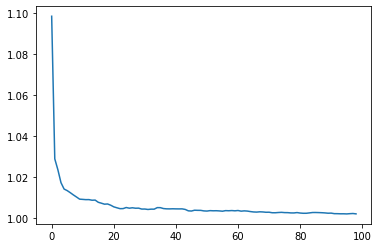

In [30]:
plt.plot(train_losses[1:])

# Inference

In [42]:
checkpoint = torch.load("patentRanker_v1.pt") 

test_model = PatentRanker() 
test_model.load_state_dict(checkpoint) 

test_model.cuda() 

Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PatentRanker(
  (word_embedding_model): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (pooling_model): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (patentBert): SentenceTransformer(
    (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
    (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=1024, out_features=1024, bias=True)
    )
    (linear1): Linear(in_features=1024, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_fea

In [43]:
test_df = pd.read_csv("test_df.tsv", sep='\t')
test_df.head() 

,queries,positive,negative
0,A system for charging or maintaining a batter...,A method for battery charger and diagnosis wi...,A ductile failure anchor for a concrete eleme...
1,A method for calculating a path delay in stat...,A non transitory computer readable medium car...,A distance evaluation method for evaluating d...
2,A preventive or therapeutic agent for diabete...,A method for measuring glutamyl transpeptidas...,A communication system comprising a plurality...
3,A semiconductor device comprising a first sem...,An integrated circuit comprising a first pitc...,canceled A lighting system comprising an opti...
4,A moveable barrier operator system comprising...,A movable barrier operator having automatic f...,A remote control system which comprises a rem...


In [148]:
candidate_embs = [] 
candidates = np.concatenate([test_df['positive'].values, test_df['negative'].values])[:1000]

In [149]:
test_model.eval() 
for i in tqdm(range(len(candidates))): 
    s = split_text(candidates[i]) 
    s = format_data(s)
    with torch.no_grad(): 
        emb = test_model(s)
    candidate_embs.append(emb) 

100%|██████████| 1000/1000 [04:51<00:00,  3.43it/s]


In [150]:
def calc_euclidean(x1, x2):
    return (x1-x2).pow(2).sum(1) 

In [168]:
queries = test_df['queries'].values 

pos = 11
q = queries[pos] 
q = split_text(q) 
q = format_data(q) 
with torch.no_grad(): 
    q_emb = test_model(q)  
    

In [169]:
distances = [] 
for i in range(len(candidate_embs)):
    d = calc_euclidean(q_emb, candidate_embs[i]) 
    d = d.detach().cpu().item()
    distances.append((d, i)) 

In [170]:
distances.sort(key = lambda x:x[0])

In [171]:
for i in range(len(distances)):
    if distances[i][1] == pos:
        print("rank : {}".format(i)) 
        break

rank : 4
